# <div class="alert alert-info"> 1. Introduction </div>

## <font color=red>1.1. Stock Price</font>

Stock price prediction has kept people intested in from a long time. It is the task of forecasting the future value of a given stock, given the historical daily close price to forecase its future prices. This analysis performs predicting Google's stock price. There are number of known approaches and new research going on in this subject. This analysis utilizes LSTM model, a class of neural networks that can predict future.  

## <font color=red>1.2. LSTM - Regression Modeling</font>

In this section we modeled our time series like a regression use case. In essence, the problem formulation though utilized past window to forecast, it did not use the time step information.

Regression Modelling referes to the proceess of investigating relationship between dependent and independent variables as a regresion problem in which the stock price at timestep t+1 (dependent variables) is a function of stockprice at timestep t, t-1, t-2,...,t-n when n is the past window of stock prices

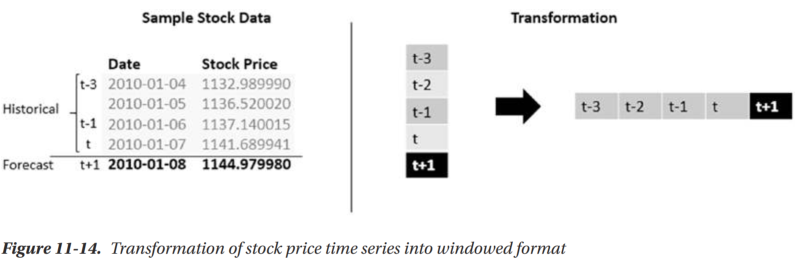

The windowed transformation is outlined in Figure 11-15 where a window size of 4 is used. The value of time t+1 is focasted using past four values. Here, Google stock price is applied this windowed transformation in a rolling fashion and create multiple sequences, each sequence has 60 values (corresponding 60 timesteps for each windowed tranformation)

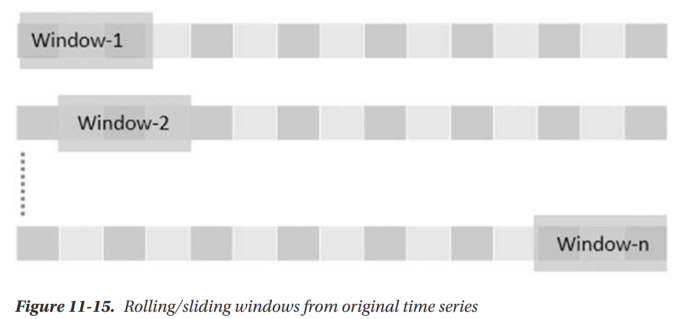

---
# <div class="alert alert-info"> 2. Setup </div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

# Keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# performance metrric
from sklearn.metrics import mean_squared_error

# utilities
import math

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

---
# <div class="alert alert-info"> 3. Data Preparation </div>

 ## <font color=red> 3.1. Load stock price from yahoo finance</font>

In [3]:
import yfinance as yf

STOCK_INDEX = 'GOOG'
VERBOSE = True

# train data from 04/01/2020 until 11/01/2020
start_train_date = '2020-04-01'
end_train_date = '2022-01-11'
train_ds = yf.download(STOCK_INDEX, start=start_train_date, end=end_train_date, progress=True)
X_train_value = train_ds.Close.values.reshape(-1,1)

# test data from 11/01/2022 until 03/11/2022
start_test_date = '2022-01-11'
end_test_date = '2022-03-11'
test_ds = yf.download(STOCK_INDEX, start=start_test_date, end=end_test_date, progress=True)
X_test_value = test_ds.Close.values.reshape(-1,1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(len(X_train_value), len(X_test_value))
train_ds.head()

449 41


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-01,1122.000000,1129.689941,1097.449951,1105.619995,1105.619995,2344200
2020-04-02,1098.260010,1126.859985,1096.400024,1120.839966,1120.839966,1964900
2020-04-03,1119.015015,1123.540039,1079.810059,1097.880005,1097.880005,2313400
2020-04-06,1138.000000,1194.660034,1130.939941,1186.920044,1186.920044,2664700
2020-04-07,1221.000000,1225.000000,1182.229980,1186.510010,1186.510010,2387300


In [5]:
train_ds.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,2911.010010,2932.199951,2876.322998,2888.330078,2888.330078,1146400
2022-01-05,2883.620117,2885.959961,2750.469971,2753.070068,2753.070068,2482100
2022-01-06,2749.949951,2793.719971,2735.270020,2751.020020,2751.020020,1452500
2022-01-07,2758.100098,2765.094971,2715.780029,2740.090088,2740.090088,970400
2022-01-10,2701.979980,2772.800049,2662.810059,2771.479980,2771.479980,1704800


---
# <div class="alert alert-info"> 4. Data Visualization </div>

<AxesSubplot:xlabel='Date'>

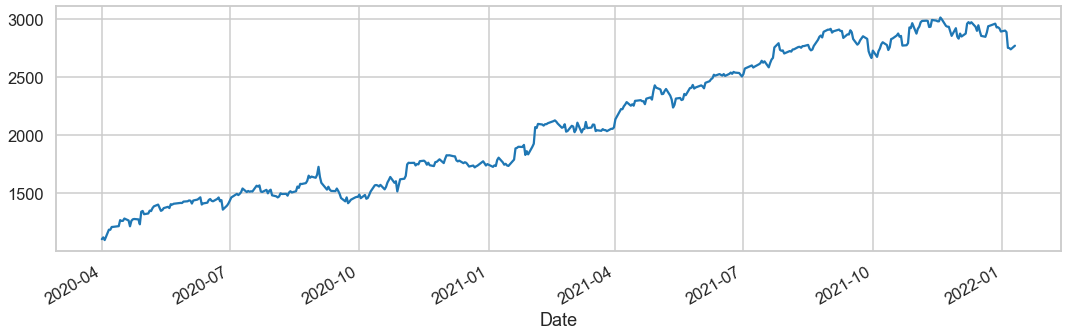

In [6]:
plt.figure(figsize=(18,5))
train_ds.Close.plot()

<AxesSubplot:xlabel='Date'>

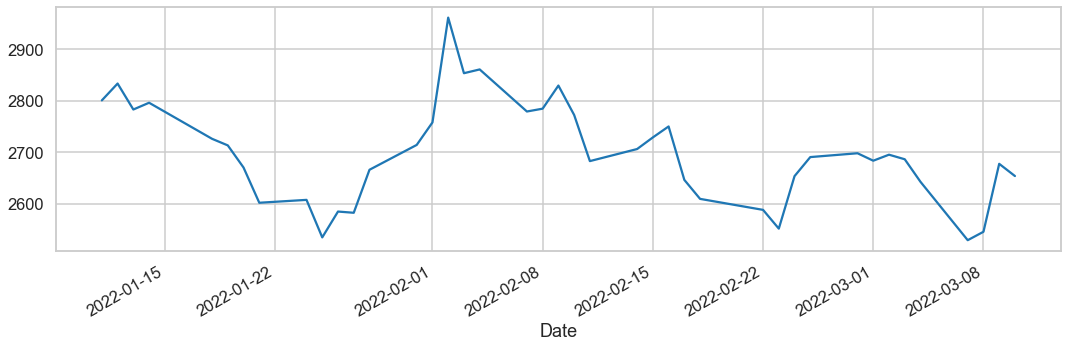

In [7]:
plt.figure(figsize=(18,5))
test_ds.Close.plot()

---
# <div class="alert alert-info"> 5. Data Preprocessing </div>

 ## <font color=red>**5.1. Set parameters**</font>

In [8]:
n_input = 60
n_features = 1

## <font color='red'>**5.2. Feature Scaling**

In [9]:
from sklearn.preprocessing import MinMaxScaler

# scale training set
sc = MinMaxScaler(feature_range=(0,1))
scaled_train = sc.fit_transform(X_train_value)

# input for preditcion the first value of test set: previous n steps before test set's first value
test_input = pd.concat([train_ds[len(train_ds) - 60:], test_ds], axis=0)
scaled_test = sc.transform(test_input.Close.values.reshape(-1,1))

scaled_train.shape, scaled_test.shape

((449, 1), (101, 1))

## <font color='red'>**5.3. Creating a data structure with 60 timesteps and 1 output**
For using LSTMs to model time series, we need to apply one more level of transformation to be able to traing data. LSTMs accept 3D tensors as input, we transform each of the windows (or sequences) in (N, W, F) format. Here, N is the number of samples or windows from the original time series, W is the size of each window or the number of historical time steps and F is number of features per time step. In this case, as only closing price is used, F is equal to 1

In [10]:
X_train  = []
y_train = []

# use last n timesteps (X) to predict the next value (y)
for i in range(n_input, len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i, 0])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape, y_train.shape

((389, 60, 1), (389,))

In [11]:
X_test = []
y_test = []

for i in range(n_input, len(scaled_test)):
    X_test.append(scaled_test[i - n_input:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# reshape data for LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
X_test.shape, y_test.shape

((41, 60, 1), (41,))

---
# <div class="alert alert-info"> 6. Building and Training the LSTM - Regression Model</div>

## <font color='red'>**6.1. Importing the Keras libraries and packages** </font>

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## <font color='red'>**6.2. Constructing LSTM**

In [13]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Clease old session
keras.backend.clear_session()
tf.keras.backend.clear_session()

# Define model
model = Sequential()
model.add(LSTM(120, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


## <font color='red'>**6.3.  Train model**

The model generates information regarding and validation loss for every epoch it runs. The callback is used for stopping enables stopping the training if there is no furthur improvement observed for four consecutive epochs.

In [14]:
model.fit(X_train, y_train, epochs = 30, batch_size = 30)

Epoch 1/30
13/13 [==============================] - 3s 39ms/step - loss: 0.0929
Epoch 2/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0131
Epoch 3/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0056
Epoch 4/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0034
Epoch 5/30
13/13 [==============================] - 0s 38ms/step - loss: 0.0031
Epoch 6/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0029
Epoch 7/30
13/13 [==============================] - 1s 39ms/step - loss: 0.0026
Epoch 8/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0029
Epoch 9/30
13/13 [==============================] - 1s 39ms/step - loss: 0.0024
Epoch 10/30
13/13 [==============================] - 1s 40ms/step - loss: 0.0026
Epoch 11/30
13/13 [==============================] - 1s 39ms/step - loss: 0.0026
Epoch 12/30
13/13 [==============================] - 1s 41ms/step - loss: 0.0028
Epoch 13/30
13/13 [==================

## <font color='red'>**6.4. Show training history**

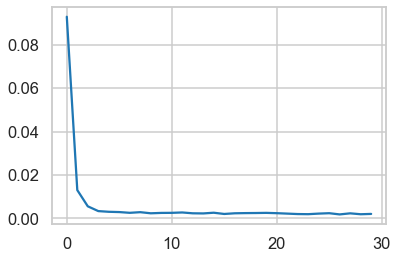

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

---
# <div class="alert alert-info"> 7. Predicting for next time step</div>

## <font color='red'>**7.1. Prediction**

In [16]:
prediction = model.predict(X_test)
prediction = prediction.reshape(-1,1)
prediction = sc.inverse_transform(prediction)
prediction[0:10]

array([[2795.8887],
       [2780.0012],
       [2771.463 ],
       [2763.9214],
       [2758.9932],
       [2750.3376],
       [2739.3398],
       [2724.3152],
       [2702.4849],
       [2678.9485]], dtype=float32)

In [17]:
test_ds['Prediction'] = prediction
test_ds.head(10)

,Open,High,Low,Close,Adj Close,Volume,Prediction
Date,,,,,,,
2022-01-11,2763.610107,2806.590088,2736.270020,2800.350098,2800.350098,1175100,2795.888672
2022-01-12,2831.090088,2856.284912,2822.239990,2832.959961,2832.959961,1182100,2780.001221
2022-01-13,2836.810059,2863.709961,2778.280029,2782.620117,2782.620117,1328300,2771.462891
2022-01-14,2750.000000,2824.010010,2750.000000,2795.729980,2795.729980,1191300,2763.921387
2022-01-18,2732.000000,2747.830078,2712.340088,2725.810059,2725.810059,1369100,2758.993164
2022-01-19,2738.770020,2767.989990,2710.000000,2713.040039,2713.040039,1039800,2750.337646
2022-01-20,2730.280029,2758.239990,2662.889893,2670.129883,2670.129883,1096500,2739.339844
2022-01-21,2660.239990,2695.209961,2600.020020,2601.840088,2601.840088,2096000,2724.315186
2022-01-24,2520.550049,2615.570068,2492.839111,2607.439941,2607.439941,2757400,2702.484863


## <font color='red'>**7.2. Visualizing the results**

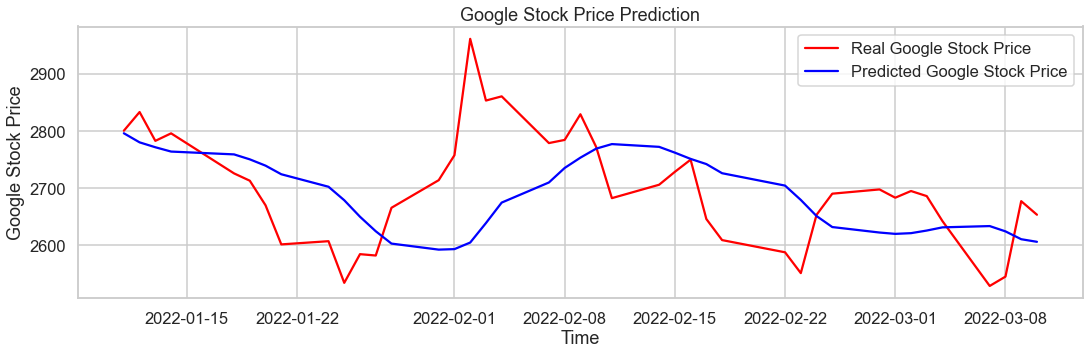

In [18]:
plt.figure(figsize=(18,5))
plt.plot(test_ds.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## <font color='red'>**7.3. Model Performance**

In [19]:
import math

test_rmse = math.sqrt(mean_squared_error(test_ds['Close'] , test_ds['Prediction'] ))
test_rmse

103.63645701217433

---
# <div class="alert alert-info"> 8. Forecast 60 time steps ahead</div>

In [20]:
start_forecast_date = '2022-01-11'
end_forecast_date = '2022-03-11'
forecast_ds = yf.download(STOCK_INDEX, start=start_forecast_date, end=end_forecast_date, progress=True)
X_forecast_value = forecast_ds.Close.values.reshape(-1,1)
scaled_forecast = sc.transform(forecast_ds.Close.values.reshape(-1, 1))

X_forecast = []
y_forecast = []


# use last 60 timesteps (X) to predict the next value (y)
for i in range(n_input, len(scaled_test)):
    X_forecast.append(scaled_test[i-n_input:i, 0])
    y_forecast.append(scaled_test[i, 0])
X_forecast = np.array(X_forecast)

# reshape data for LSTM model
X_forecast = np.reshape(X_forecast, (X_forecast.shape[0], X_forecast.shape[1], n_features))
X_forecast.shape

[*********************100%***********************]  1 of 1 completed


(41, 60, 1)

In [21]:
forecast = []

first_batch = scaled_forecast[0:n_input, 0]
current_batch = X_forecast[0,:,:].reshape((1, n_input, n_features))

for i in range(len(X_forecast)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    #print(current_pred)
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [22]:
#total = np.concatenate([first_eval_batch , np.array(forecast).flatten()])
#total = total.reshape(-1,1)
true_forecast = sc.inverse_transform(forecast)
forecast_ds['Forecast'] = true_forecast

forecast_ds.head()

,Open,High,Low,Close,Adj Close,Volume,Forecast
Date,,,,,,,
2022-01-11,2763.610107,2806.590088,2736.270020,2800.350098,2800.350098,1175100,2795.888459
2022-01-12,2831.090088,2856.284912,2822.239990,2832.959961,2832.959961,1182100,2779.630787
2022-01-13,2836.810059,2863.709961,2778.280029,2782.620117,2782.620117,1328300,2766.485393
2022-01-14,2750.000000,2824.010010,2750.000000,2795.729980,2795.729980,1191300,2755.359757
2022-01-18,2732.000000,2747.830078,2712.340088,2725.810059,2725.810059,1369100,2745.603509


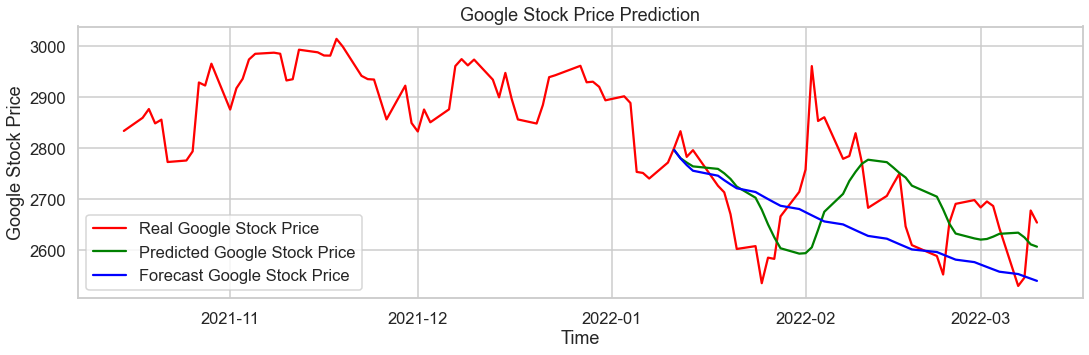

In [23]:
plt.figure(figsize=(18,5))
plt.plot(test_input.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'green', label = 'Predicted Google Stock Price')
plt.plot(forecast_ds.Forecast, color = 'blue', label = 'Forecast Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [24]:
ds = pd.concat([train_ds, test_ds], axis=0)

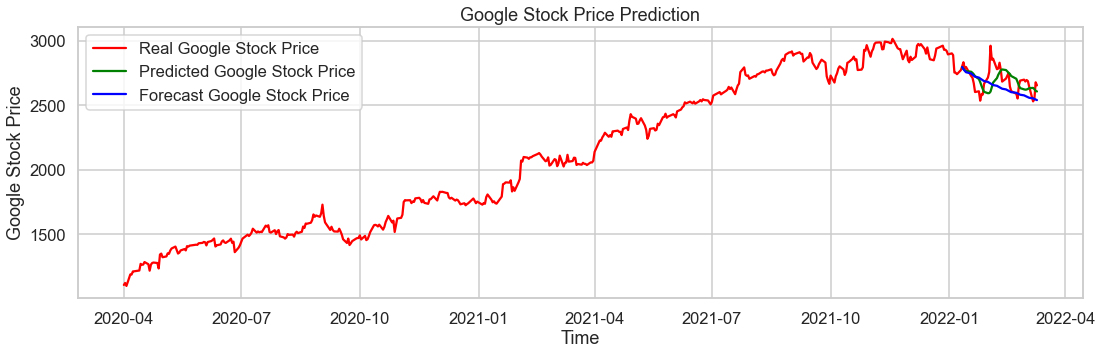

In [25]:
plt.figure(figsize=(18,5))
plt.plot(ds.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'green', label = 'Predicted Google Stock Price')
plt.plot(forecast_ds.Forecast, color = 'blue', label = 'Forecast Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()